This contains code to make the plots in figure 1 of the interpretability paper

In [1]:
# NEED TO USE TADA_V2 kernel to be able to load the modles
import numpy as np
import pandas as pd
import tensorflow as tf # tested on version 2.2.0
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.sans-serif'] = 'Arial'
from matplotlib import pyplot as plt
from joblib import load
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import seaborn as sns


import os

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/NN_interpretability_for_AD_prediction/scripts")
from Model import ADModel_act, ADModel_abund
from Data import DataReader, SplitData, FastTensorDataLoader, one_hot_encode

os.chdir("/Users/claireleblanc/Documents/tools_software/PADDLE")

import paddle


os.chdir("/Users/claireleblanc/Documents/tools_software/adhunter")
from actpred.models import ActCNNSystem

# Set Numpy to display floats with 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/NN_interpretability_for_AD_prediction")

In [2]:
import matplotlib 
# For higher resoltion figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica" #somethings this one doesnt work
plt.rcParams['pdf.fonttype'] = 42

In [3]:
# READING IN FULL LENGTH VALIDATION SEQUENCES AND TILE DATA

data = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/Unique_502_Gcn4_Seqs.csv", index_col=0)
val_seqs= data[data["heirarchical"] == 1]
train_seqs = data[data["heirarchical"] != 1]

tile_data = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/pm_gcn4_sort2_pools_allchannels_wrangled.csv")

activity_dict = {}
for i in tile_data.index:
    activity_dict[tile_data.loc[i,"aa_seq"]] = tile_data.loc[i,"activity"]

abund_dict = {}
for i in tile_data.index:
    abund_dict[tile_data.loc[i,"aa_seq"]] = tile_data.loc[i,"abundance"]

used_tiles = []

def get_tile_activity(tile):
    used_tiles.append(tile)
    return activity_dict.get(tile)

def get_tile_abundance(tile):
    return abund_dict.get(tile)


# Break full length seqs into tiles, adding in the final tile
val_seqs["53_tiles"] = [[seq[i:i+53] for i in range(0,len(seq)-52)] + [seq[-53:]] for seq in val_seqs["Sequence"]]
val_seqs["53_tile_centers"] = [[i + 53/2 for i in range(0,len(seq)-52)] + [len(seq)-53/2] for seq in val_seqs["Sequence"]]

val_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in val_seqs["Sequence"]]
val_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in val_seqs["Sequence"]]

# This is for more valid comparison with the other predictors
val_seqs["40_tiles_adjacent"] = [[seq[i:i+40] for i in range(0,len(seq)-39)] + [seq[-40:]] for seq in val_seqs["Sequence"]]
val_seqs["40_tile_centers_adjacent"] = [[i+20 for i in range(0,len(seq)-39)] + [len(seq)-20] for seq in val_seqs["Sequence"]]

val_seqs["30_tile_centers"] = [[i for i in range(len(seq))] for seq in val_seqs["Sequence"]]

val_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in val_seqs["40_tiles"]]
val_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in val_seqs["40_tiles"]]


train_seqs["53_tiles"] = [[seq[i:i+53] for i in range(0,len(seq)-52)] + [seq[-53:]] for seq in train_seqs["Sequence"]]
train_seqs["53_tile_centers"] = [[i + 53/2 for i in range(0,len(seq)-52)] + [len(seq)-53/2] for seq in train_seqs["Sequence"]]
train_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in train_seqs["Sequence"]]
train_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in train_seqs["Sequence"]]
train_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in train_seqs["40_tiles"]]
train_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in train_seqs["40_tiles"]]

unused_tiles = list(set(tile_data["aa_seq"]).difference(set(used_tiles)))
other_tiles = pd.DataFrame(unused_tiles, columns=["aa_seq"])
other_tiles["activity"] = [get_tile_activity(s) for s in other_tiles["aa_seq"]]
other_tiles["abundance"] = [get_tile_abundance(s) for s in other_tiles["aa_seq"]]


/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_8055/550933801.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_seqs["53_tiles"] = [[seq[i:i+53] for i in range(0,len(seq)-52)] + [seq[-53:]] for seq in val_seqs["Sequence"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_8055/550933801.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_seqs["53_tile_centers"] = [[i + 53/2 for i in range(0,len(seq)-52)] + [len(seq)-53/2] for seq in val_seqs["Sequence"]]
/var/folders/34/1pw3

In [15]:
# BIOPHYSICAL MODEL STUFF
import torch

size = (1,40,20)
positive = False
activity_fun = "Hill"
hill_value = 1
relu = False
kernel_size = 10
outchannel = 1
model = "model_data/simple_actmodel_b10_e200_L0.0001_sMinMax_c1_k10_wp0.1_ParaReLU_hSplit_seed1792777_weightInit"
biophysical_model = ADModel_act(size,kernel_size)
biophysical_model.load_state_dict(torch.load(f"{model}.pth"))

biophysical_model.eval()
sc_act = load("scripts/scaler_activity.bin")

def run_biophysical_model(loaded_model,sequence):
    encoded_seq = one_hot_encode(sequence).reshape(1,1,40,20)
    seq_tensor = torch.from_numpy(encoded_seq).type(torch.FloatTensor)
    predictions = loaded_model(seq_tensor)
    predictions = predictions.detach().numpy().reshape(1, -1)
    return sc_act.inverse_transform(predictions)

val_seqs["biophysics_gfp_pred"] = [[run_biophysical_model(biophysical_model, tile)[0][0] for tile in tiles] for tiles in val_seqs["40_tiles"]]
train_seqs["biophysics_gfp_pred"] = [[run_biophysical_model(biophysical_model, tile)[0][0] for tile in tiles] for tiles in train_seqs["40_tiles"]]
other_tiles["biophysics_gfp_pred"] = [run_biophysical_model(biophysical_model, tile)[0][0] for tile in other_tiles["aa_seq"]]

val_seqs["biophysics_gfp_pred_adjacent"] = [[run_biophysical_model(biophysical_model, tile)[0][0] for tile in tiles] for tiles in val_seqs["40_tiles_adjacent"]]

/Users/claireleblanc/miniconda3/envs/predictors_simple/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
# ADHUNTER STUFF
kernel_size = 5
dilation = 3 
hidden = 64

gfp_model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
gfp_model.load_state_dict(torch.load("../../../tools_software/adhunter/adhunter_gfp.pt"))
gfp_model.eval()

mcherry_model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
mcherry_model.load_state_dict(torch.load("../../../tools_software/adhunter/adhunter_cherry.pt"))
mcherry_model.eval()

sc_gfp=load('../../../tools_software/adhunter/scaler_gfp.pkl')
sc_mcherry=load('../../../tools_software/adhunter/scaler_cherry.pkl')

alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}

def run_adhunter(model, sequence, sc):
    X = np.asarray([[aa_to_i[aa] for aa in sequence]])
    X = torch.tensor(X)
    result = model(X)
    result = sc.inverse_transform(result.detach().numpy().reshape(-1, 1))
    return result[0,0]


# Predict ADHunter score for each 40aa tile in the validation data set
val_seqs["adhunter_gfp_pred"] = [[run_adhunter(gfp_model, tile, sc_gfp) for tile in tiles] for tiles in val_seqs["40_tiles"]]
val_seqs["adhunter_gfp_pred_adjacent"] = [[run_adhunter(gfp_model, tile, sc_gfp) for tile in tiles] for tiles in val_seqs["40_tiles_adjacent"]]

val_seqs["adhunter_mcherry_pred"] = [[run_adhunter(mcherry_model, tile, sc_mcherry) for tile in tiles] for tiles in val_seqs["40_tiles"]]

other_tiles["adhunter_gfp_pred"] = [run_adhunter(gfp_model, tile, sc_gfp) for tile in other_tiles["aa_seq"]]
other_tiles["adhunter_mcherry_pred"] = [run_adhunter(mcherry_model, tile, sc_mcherry) for tile in other_tiles["aa_seq"]]

/Users/claireleblanc/miniconda3/envs/predictors_simple/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_8055/2645437400.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_seqs["adhunter_gfp_pred"] = [[run_adhunter(gfp_model, tile, sc_gfp) for tile in tiles] for tiles in val_seqs["40_tiles"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_8055/2645437400.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [6]:
# LOAD PADDLE STUFF - CURRENTLY DOESN'T WORK :(
pad_noSS = paddle.PADDLE_noSS()

paddle_preds = []
for tiles in val_seqs["53_tiles"]:
    paddle_pred = pad_noSS.predict(tiles)
    paddle_preds.append(paddle_pred)

val_seqs["paddle_preds"] = paddle_preds

Loading model split 1 of 10
Loading model split 2 of 10
Loading model split 3 of 10
Loading model split 4 of 10
Loading model split 5 of 10
Loading model split 6 of 10
Loading model split 7 of 10
Loading model split 8 of 10
Loading model split 9 of 10
Loading model split 10 of 10


2025-08-14 12:14:56.245195: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_8055/590428278.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_seqs["paddle_preds"] = paddle_preds


In [7]:
# LOAD ADPred Preds
adpred_df = pd.read_csv("/Users/claireleblanc/Downloads/ADpred_preds.csv", index_col=0, converters={'adpred_preds' : pd.eval})
adpred_df.columns = ["Sequence", "adpred_preds"]
val_seqs = val_seqs.merge(adpred_df, on="Sequence")
train_seqs = train_seqs.merge(adpred_df, on="Sequence")


In [8]:
# LOAD TADA Preds
import pickle 

with open('/Users/claireleblanc/Downloads/TADA_preds.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

tada_df = pd.DataFrame(loaded_data).T.reset_index()
tada_df.columns = ["Sequence", "tada_centers", "tada_preds"]

val_seqs = val_seqs.merge(tada_df, on="Sequence")
train_seqs = train_seqs.merge(tada_df, on="Sequence")

In [9]:
import loess
from loess import loess_1d
from collections import defaultdict 
from tqdm import tqdm

def smooth_data(x_col_name, y_col_name):
    SmoothedActivitesLoess = defaultdict()
    # maxActivity = max(tile_data["activity"])
    # minActivity = min(tile_data["activity"])
    OrthologLengths = dict(zip(val_seqs["Name"],val_seqs["Length"]))

    for i, idx in tqdm(enumerate((val_seqs.index))): # for each TF
        species = val_seqs.loc[idx,"Name"]
        Y = val_seqs.loc[idx,y_col_name]
        X = val_seqs.loc[idx,x_col_name]

        # Filter out None values and corresponding Y values
        filtered_XY = [(x,y) for x, y in zip(X, Y) if y != None]

        # Separate the filtered values back into two lists
        filtered_X, filtered_Y = zip(*filtered_XY) if filtered_XY else ([], [])
        filtered_X = np.array(filtered_X)
        filtered_Y = np.array(filtered_Y)
        
        # do the actual smoothing
        xout, yout, wout = loess.loess_1d.loess_1d(filtered_X, filtered_Y, xnew=range(OrthologLengths[species]), degree=2, 
                                npoints=20, rotate=False, sigy=None)
        modyout = yout

        # make it so that the ends are less wonky
        start = max(yout[20],0)
        modyout[0:20] = start
        end = max(yout[-20],0)
        modyout[-20:] = end
        
        # Make sure activity is not greated than max experimental activity
        # modyout2 = np.clip(modyout,a_min=minActivity,a_max=maxActivity)
        modyout2 = modyout
        SmoothedActivitesLoess[species] = modyout2

    return SmoothedActivitesLoess

def get_centered_smoothed_data(data_column_name, smooth_experimental=True):
    pred_vals = []
    experimental_vals = []

    for i in val_seqs.index:
        centers = val_seqs.loc[i,"40_tile_centers"]
        for center in centers:
            try: 
                pred_center_value = val_seqs.loc[i, data_column_name][center]
                pred_vals.append(pred_center_value)
                
                if not smooth_experimental:
                    exp_center_idx = val_seqs.loc[i, "40_tile_centers"].index(center)
                else:
                    exp_center_idx = center
                    
                exp_center_value = val_seqs.loc[i, "smoothed_experimental"][exp_center_idx]
                experimental_vals.append(exp_center_value)
            except:
                continue

    return experimental_vals, pred_vals

In [17]:
val_seqs["Length"] = [len(s) for s in val_seqs["Sequence"]]
tempSeries = val_seqs["Name"]
smoothed_exp = smooth_data("40_tile_centers","40_tiles_exp_activities")
smoothed_biophysical = smooth_data("40_tile_centers_adjacent","biophysics_gfp_pred_adjacent")
smoothed_adhunter = smooth_data("40_tile_centers_adjacent","adhunter_gfp_pred_adjacent")
smoothed_paddle = smooth_data("53_tile_centers","paddle_preds")

smoothed_tada = smooth_data("tada_centers", "tada_preds")
smoothed_adpred = smooth_data("30_tile_centers", "adpred_preds")

val_seqs['smoothed_experimental'] = tempSeries.map(smoothed_exp)
val_seqs['smoothed_biophysical'] = tempSeries.map(smoothed_biophysical)
val_seqs['smoothed_adhunter'] = tempSeries.map(smoothed_adhunter)
val_seqs['smoothed_paddle'] = tempSeries.map(smoothed_paddle)
val_seqs["smoothed_tada"] = tempSeries.map(smoothed_tada)
val_seqs["smoothed_adpred"] = tempSeries.map(smoothed_adpred)

63it [00:02, 25.58it/s]
63it [00:02, 24.99it/s]
63it [00:02, 25.48it/s]
63it [00:02, 25.38it/s]
63it [00:02, 25.20it/s]
63it [00:02, 24.60it/s]


In [18]:
val_seqs = val_seqs.reset_index()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


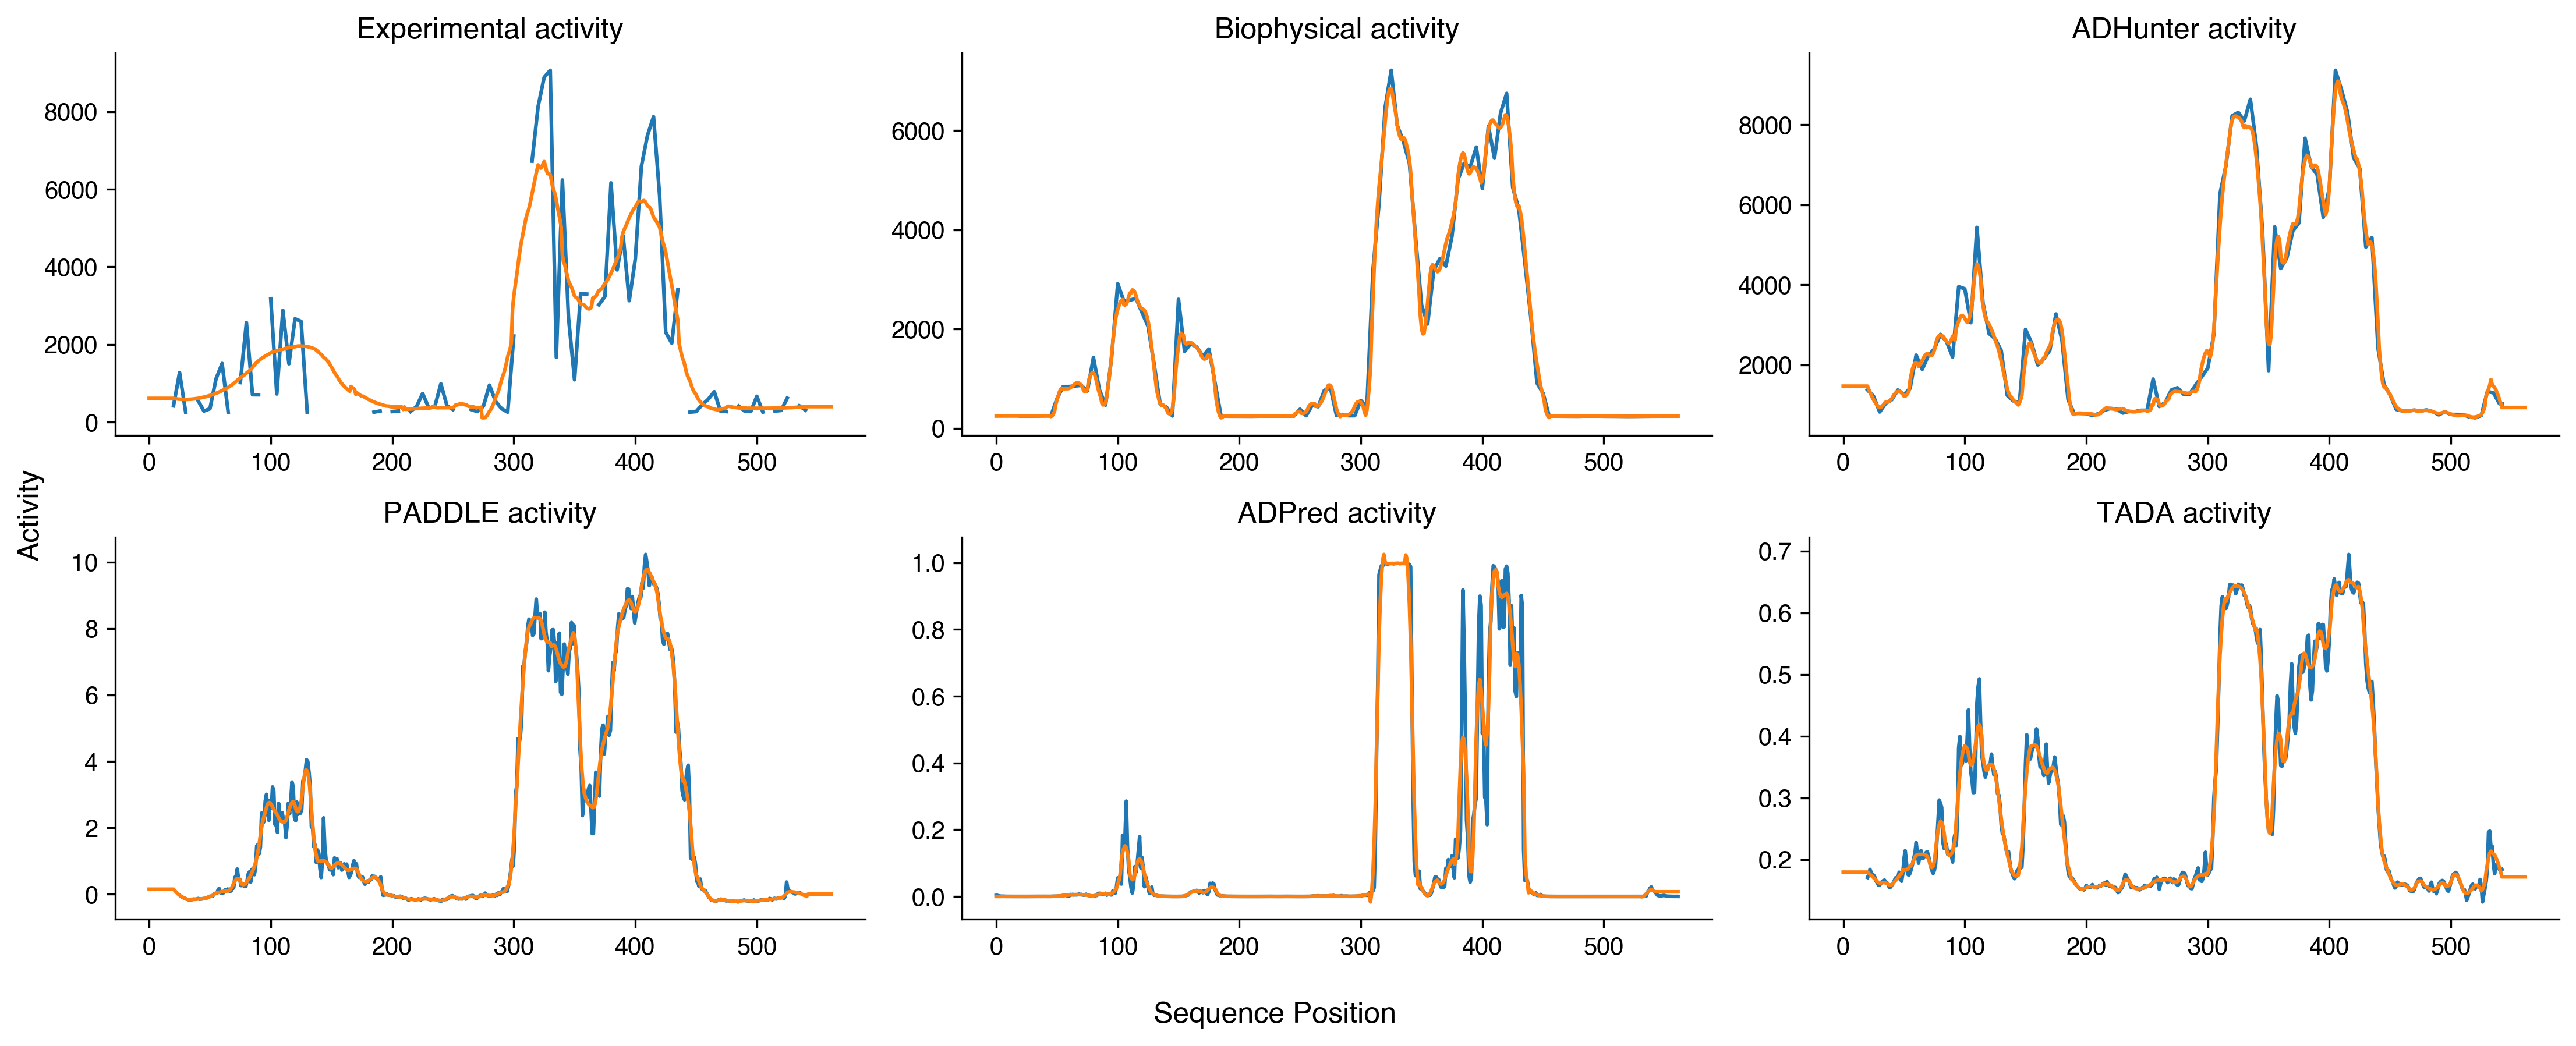

In [19]:
fig, axs = plt.subplots(2,3,figsize=(15,6))

i = 5
axs[0,0].plot(val_seqs.loc[i,"40_tile_centers"], val_seqs.loc[i,"40_tiles_exp_activities"], label="Original")
axs[0,0].plot(range(val_seqs.loc[i,"Length"]), val_seqs.loc[i,"smoothed_experimental"], label="Smoothed")
axs[0,0].set_title("Experimental activity")

axs[0,1].plot(val_seqs.loc[i,"40_tile_centers"], val_seqs.loc[i,"biophysics_gfp_pred"], label="Original")
axs[0,1].plot(range(val_seqs.loc[i,"Length"]), val_seqs.loc[i,"smoothed_biophysical"], label="Smoothed")
axs[0,1].set_title("Biophysical activity")

axs[0,2].plot(val_seqs.loc[i,"40_tile_centers"], val_seqs.loc[i,"adhunter_gfp_pred"], label="Original")
axs[0,2].plot(range(val_seqs.loc[i,"Length"]), val_seqs.loc[i,"smoothed_adhunter"], label="Smoothed")
axs[0,2].set_title("ADHunter activity")

axs[1,0].plot(val_seqs.loc[i,"53_tile_centers"], val_seqs.loc[i,"paddle_preds"], label="Original")
axs[1,0].plot(range(val_seqs.loc[i,"Length"]), val_seqs.loc[i,"smoothed_paddle"], label="Smoothed")
axs[1,0].set_title("PADDLE activity")


axs[1,1].plot(range(val_seqs.loc[i,"Length"]), val_seqs.loc[i,"adpred_preds"], label="Original")
axs[1,1].plot(range(val_seqs.loc[i,"Length"]), val_seqs.loc[i,"smoothed_adpred"], label="Smoothed")
axs[1,1].set_title("ADPred activity")

axs[1,2].plot(val_seqs.loc[i,"tada_centers"], val_seqs.loc[i,"tada_preds"], label="Original")
axs[1,2].plot(range(val_seqs.loc[i,"Length"]), val_seqs.loc[i,"smoothed_tada"], label="Smoothed")
axs[1,2].set_title("TADA activity")


fig.supxlabel("Sequence Position")
fig.supylabel("Activity")

handles, labels = axs[0,0].get_legend_handles_labels()
fig.tight_layout()
# fig.legend(handles, labels, bbox_to_anchor=(1, 0.6))


sns.despine()

plt.savefig(f"figures/smoothed_data.pdf", format='pdf', bbox_inches='tight')
plt.savefig(f"figures/smoothed_data.png")


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


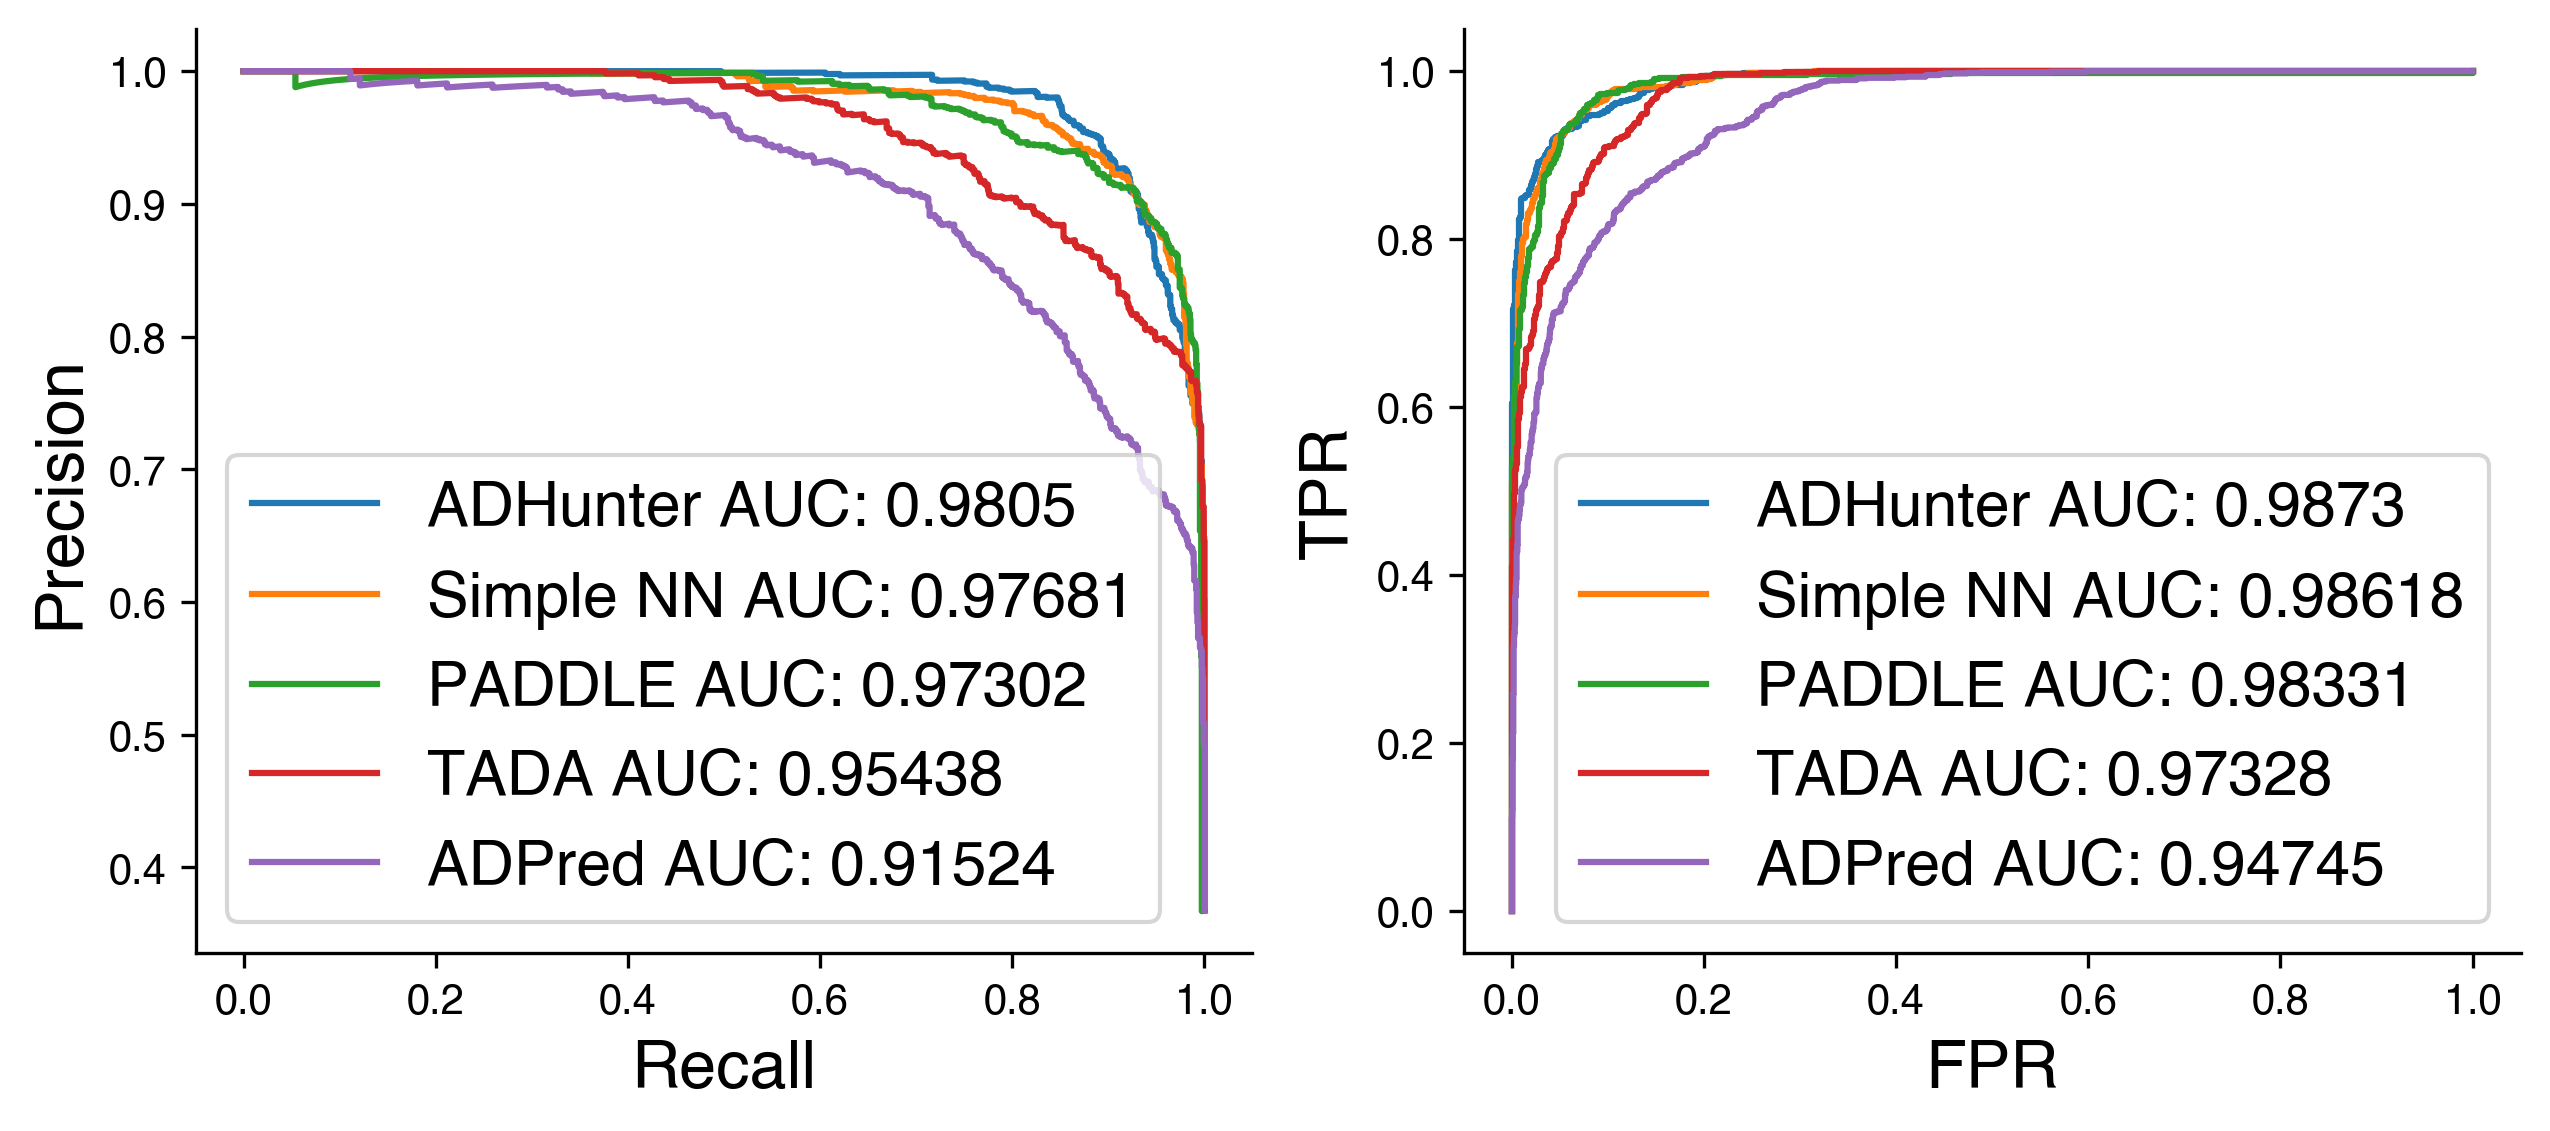

In [26]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

# This only looks at val_seqs
experimental_measures, biophysical_measures = get_centered_smoothed_data("smoothed_biophysical")
experimental_labels = [i > 2000 for i in experimental_measures]
precision_b, recall_b, thresholds_b = precision_recall_curve(experimental_labels, biophysical_measures)
fpr_b, tpr_b, thresholds_b = roc_curve(experimental_labels, biophysical_measures)

experimental_measures, paddle_measures = get_centered_smoothed_data("smoothed_paddle")
experimental_labels = [i > 2000 for i in experimental_measures]
precision_p, recall_p, thresholds_p = precision_recall_curve(experimental_labels, paddle_measures)
fpr_p, tpr_p, thresholds_p = roc_curve(experimental_labels, paddle_measures)

experimental_measures, adhunter_measures = get_centered_smoothed_data("smoothed_adhunter")
experimental_labels = [i > 2000 for i in experimental_measures]
precision_a, recall_a, thresholds_a = precision_recall_curve(experimental_labels, adhunter_measures)
fpr_a, tpr_a, thresholds_a = roc_curve(experimental_labels, adhunter_measures)

experimental_measures, tada_measures = get_centered_smoothed_data("smoothed_tada")
experimental_labels = [i > 2000 for i in experimental_measures]
precision_t, recall_t, thresholds_t = precision_recall_curve(experimental_labels, tada_measures)
fpr_t, tpr_t, thresholds_t = roc_curve(experimental_labels, tada_measures)

experimental_measures, adpred_measures = get_centered_smoothed_data("adpred_preds")
experimental_labels = [i > 2000 for i in experimental_measures]
precision_ad, recall_ad, thresholds_ad = precision_recall_curve(experimental_labels, adpred_measures)
fpr_ad, tpr_ad, thresholds_ad = roc_curve(experimental_labels, adpred_measures)


biophysics_auc_pr = auc(recall_b, precision_b)
adhunter_auc_pr = auc(recall_a, precision_a)
paddle_auc_pr = auc(recall_p, precision_p)
tada_auc_pr = auc(recall_t, precision_t)
adpred_auc_pr = auc(recall_ad, precision_ad)

biophysics_auc_roc = auc(fpr_b, tpr_b)
adhunter_auc_roc = auc(fpr_a, tpr_a)
paddle_auc_roc = auc(fpr_p, tpr_p)
tada_auc_roc = auc(fpr_t, tpr_t)
adpred_auc_roc = auc(fpr_ad, tpr_ad)

axs[0].plot(recall_a, precision_a, label=f"ADHunter AUC: {adhunter_auc_pr:.5}")
axs[0].plot(recall_b, precision_b, label=f"Simple NN AUC: {biophysics_auc_pr:.5}")
axs[0].plot(recall_p, precision_p, label=f"PADDLE AUC: {paddle_auc_pr:.5}")
axs[0].plot(recall_t, precision_t, label=f"TADA AUC: {tada_auc_pr:.5}")
axs[0].plot(recall_ad, precision_ad, label=f"ADPred AUC: {adpred_auc_pr:.5}")

axs[0].legend(fontsize="15")
axs[0].set_xlabel("Recall", fontsize=16)
axs[0].set_ylabel("Precision", fontsize=16)

axs[1].plot(fpr_a,tpr_a,  label=f"ADHunter AUC: {adhunter_auc_roc:.5}")
axs[1].plot(fpr_b, tpr_b, label=f"Simple NN AUC: {biophysics_auc_roc:.5}")
axs[1].plot(fpr_p, tpr_p, label=f"PADDLE AUC: {paddle_auc_roc:.5}")
axs[1].plot(fpr_t, tpr_t, label=f"TADA AUC: {tada_auc_roc:.5}")
axs[1].plot(fpr_ad, tpr_ad, label=f"ADPred AUC: {adpred_auc_roc:.5}")

axs[1].legend(fontsize="15")
axs[1].set_xlabel("FPR", fontsize=16)
axs[1].set_ylabel("TPR", fontsize=16)

# fig.suptitle("Centered and Smoothed Data")
sns.despine()
plt.savefig(f"figures/simple_AUC_plots.pdf", format='pdf', bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


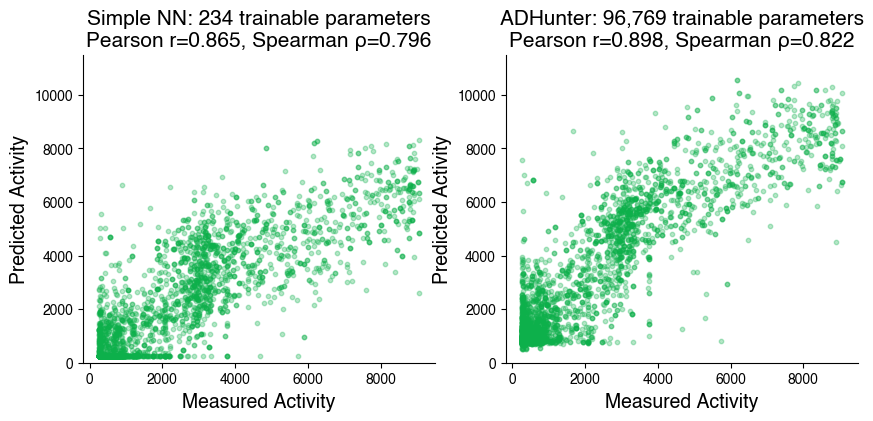

In [ ]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


fig, axs = plt.subplots(1,2,figsize=(10,4))

tiles = [i for ls in val_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"]))
actual = [i for ls in val_seqs["40_tiles_exp_activities"] for i in ls]
actual = actual + (list(other_tiles["activity"]))
pred = [i for ls in val_seqs["biophysics_gfp_pred"] for i in ls]
pred = pred + (list(other_tiles["biophysics_gfp_pred"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") 

axs[0].scatter(actual, pred, color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"].astype(float), plotting_data["pred"].astype(float)).correlation
pearson = pearsonr(plotting_data["actual"].astype(float), plotting_data["pred"].astype(float)).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
axs[0].set_ylim(0, 11500)
axs[0].set_title(f'Simple NN: 234 trainable parameters\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

tiles = [i for ls in val_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"]))
actual = [i for ls in val_seqs["40_tiles_exp_activities"] for i in ls]
actual = actual + (list(other_tiles["activity"]))
pred = [i for ls in val_seqs["adhunter_gfp_pred"] for i in ls]
pred = pred + (list(other_tiles["adhunter_gfp_pred"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") 

axs[1].scatter(actual, pred, color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"].astype(float), plotting_data["pred"].astype(float)).correlation
pearson = pearsonr(plotting_data["actual"].astype(float), plotting_data["pred"].astype(float)).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
axs[1].set_ylim(0, 11500)
axs[1].set_title(f'ADHunter: 96,769 trainable parameters\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

sns.despine()
plt.savefig("figures/simple_activity_scatter_plots.pdf", format='pdf', bbox_inches='tight')

# Make convolutional filter plots

In [ ]:
amino_acids = ["R","K","H","D","E","M","I","L","V","A","F","Y","W","Q","N","S","T","G","P","C"]

# Weights preparation
def get_conv_weights(model, layer): 
    model_state_dict = model.state_dict()
    width = model_state_dict[layer].shape[0] * model_state_dict[layer].shape[2]
    conv_weight = model_state_dict[layer].detach().numpy().reshape(width,20)
    conv_weights = pd.DataFrame(conv_weight,columns = ["R","H","K","D","E","S","T","N","Q","C","G","P","A","V","I","L","M","F","Y","W"])
    conv_weights = conv_weights[amino_acids]
    return conv_weights

def get_linear_weights(model, layer, kernel_size):
    linear_weights = (40 - kernel_size + 1)
    model_state_dict = model.state_dict()
    linear_weight = model_state_dict[layer].detach().numpy().reshape(linear_weights)
    x_vals = np.array(range(0,linear_weights))
    return linear_weight, x_vals


In [ ]:
conv_weight = get_conv_weights(biophysical_model, "conv1.weight").T
model_linear, model_xvals = get_linear_weights(biophysical_model, "linear1.weight", 10)

lim = max([abs(w) for w in conv_weight.values.flatten()])

In [ ]:
# Red often represents negative charges
colors = ["#4B0092", (1, 1, 1), "#0DB04B"]  # Blue, White, Red
n_bins = 100  # Number of color bins
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='white', alpha=1.0)  # Handle NaN values, if any
colors = {'A': 'purple', 'C': 'darkorange', 'E': 'blue', 'D': 'blue', 'G': 'darkorange', 
                  'F': 'indigo', 'I': 'purple', 'H': 'green', 'K': 'green', 'M': 'purple', 
                  'L': 'purple', 'N': 'darkslategray', 'Q': 'darkslategray', 'P': 'darkorange', 'S': 'darkslategray', 
                  'R': 'green', 'T': 'darkslategray', 'W': 'indigo', 'V': 'purple', 'Y': 'indigo'}

In [ ]:
def make_row_plot(fig, kernel_size, model, row, lim, height_ratios, num_rows):

    model_conv1 = get_conv_weights(model, "conv1.weight").T
    model_linear1, model_xvals1 = get_linear_weights(model, "linear1.weight", kernel_size)

    ratio1 = kernel_size 
    ratio2 = 40 - kernel_size + 1
    gs1 = gridspec.GridSpec(2 + num_rows*2, 2, width_ratios=[ratio1, ratio2], height_ratios=height_ratios, figure=fig)
    ax1 = plt.subplot(gs1[row, 0])
    ax2 = plt.subplot(gs1[row, 1])

    im1 = ax1.imshow(model_conv1.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax1.set_yticks(range(len(model_conv1.index)), model_conv1.index)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=2))
    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    # fig.colorbar(im)
    ax1.tick_params(axis='x', which='major', labelsize=15) 
    ax1.tick_params(axis='y', which='major', labelsize=8) 


    ax2.bar(model_xvals1, model_linear1, color="grey")
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_position('zero')
    ax2.spines["bottom"].set_linewidth(2.5)

    ax2.spines['bottom'].set_bounds(min(model_xvals1) - 1, max(model_xvals1) + 1)
    
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    return ax1, ax2, im1

In [ ]:
def load_model(file, kernel_size):
    model = ADModel_act(size,kernel_size)
    model.load_state_dict(torch.load(f"{file}.pth"))

    model.eval()
    return model

In [ ]:
file = "model_data/simple_actmodel_b10_e200_L0.0001_sMinMax_c1_k40_wp0.1_ParaReLU_hSplit_seed82375840_weightInit"
model_40 = load_model(file, 40)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


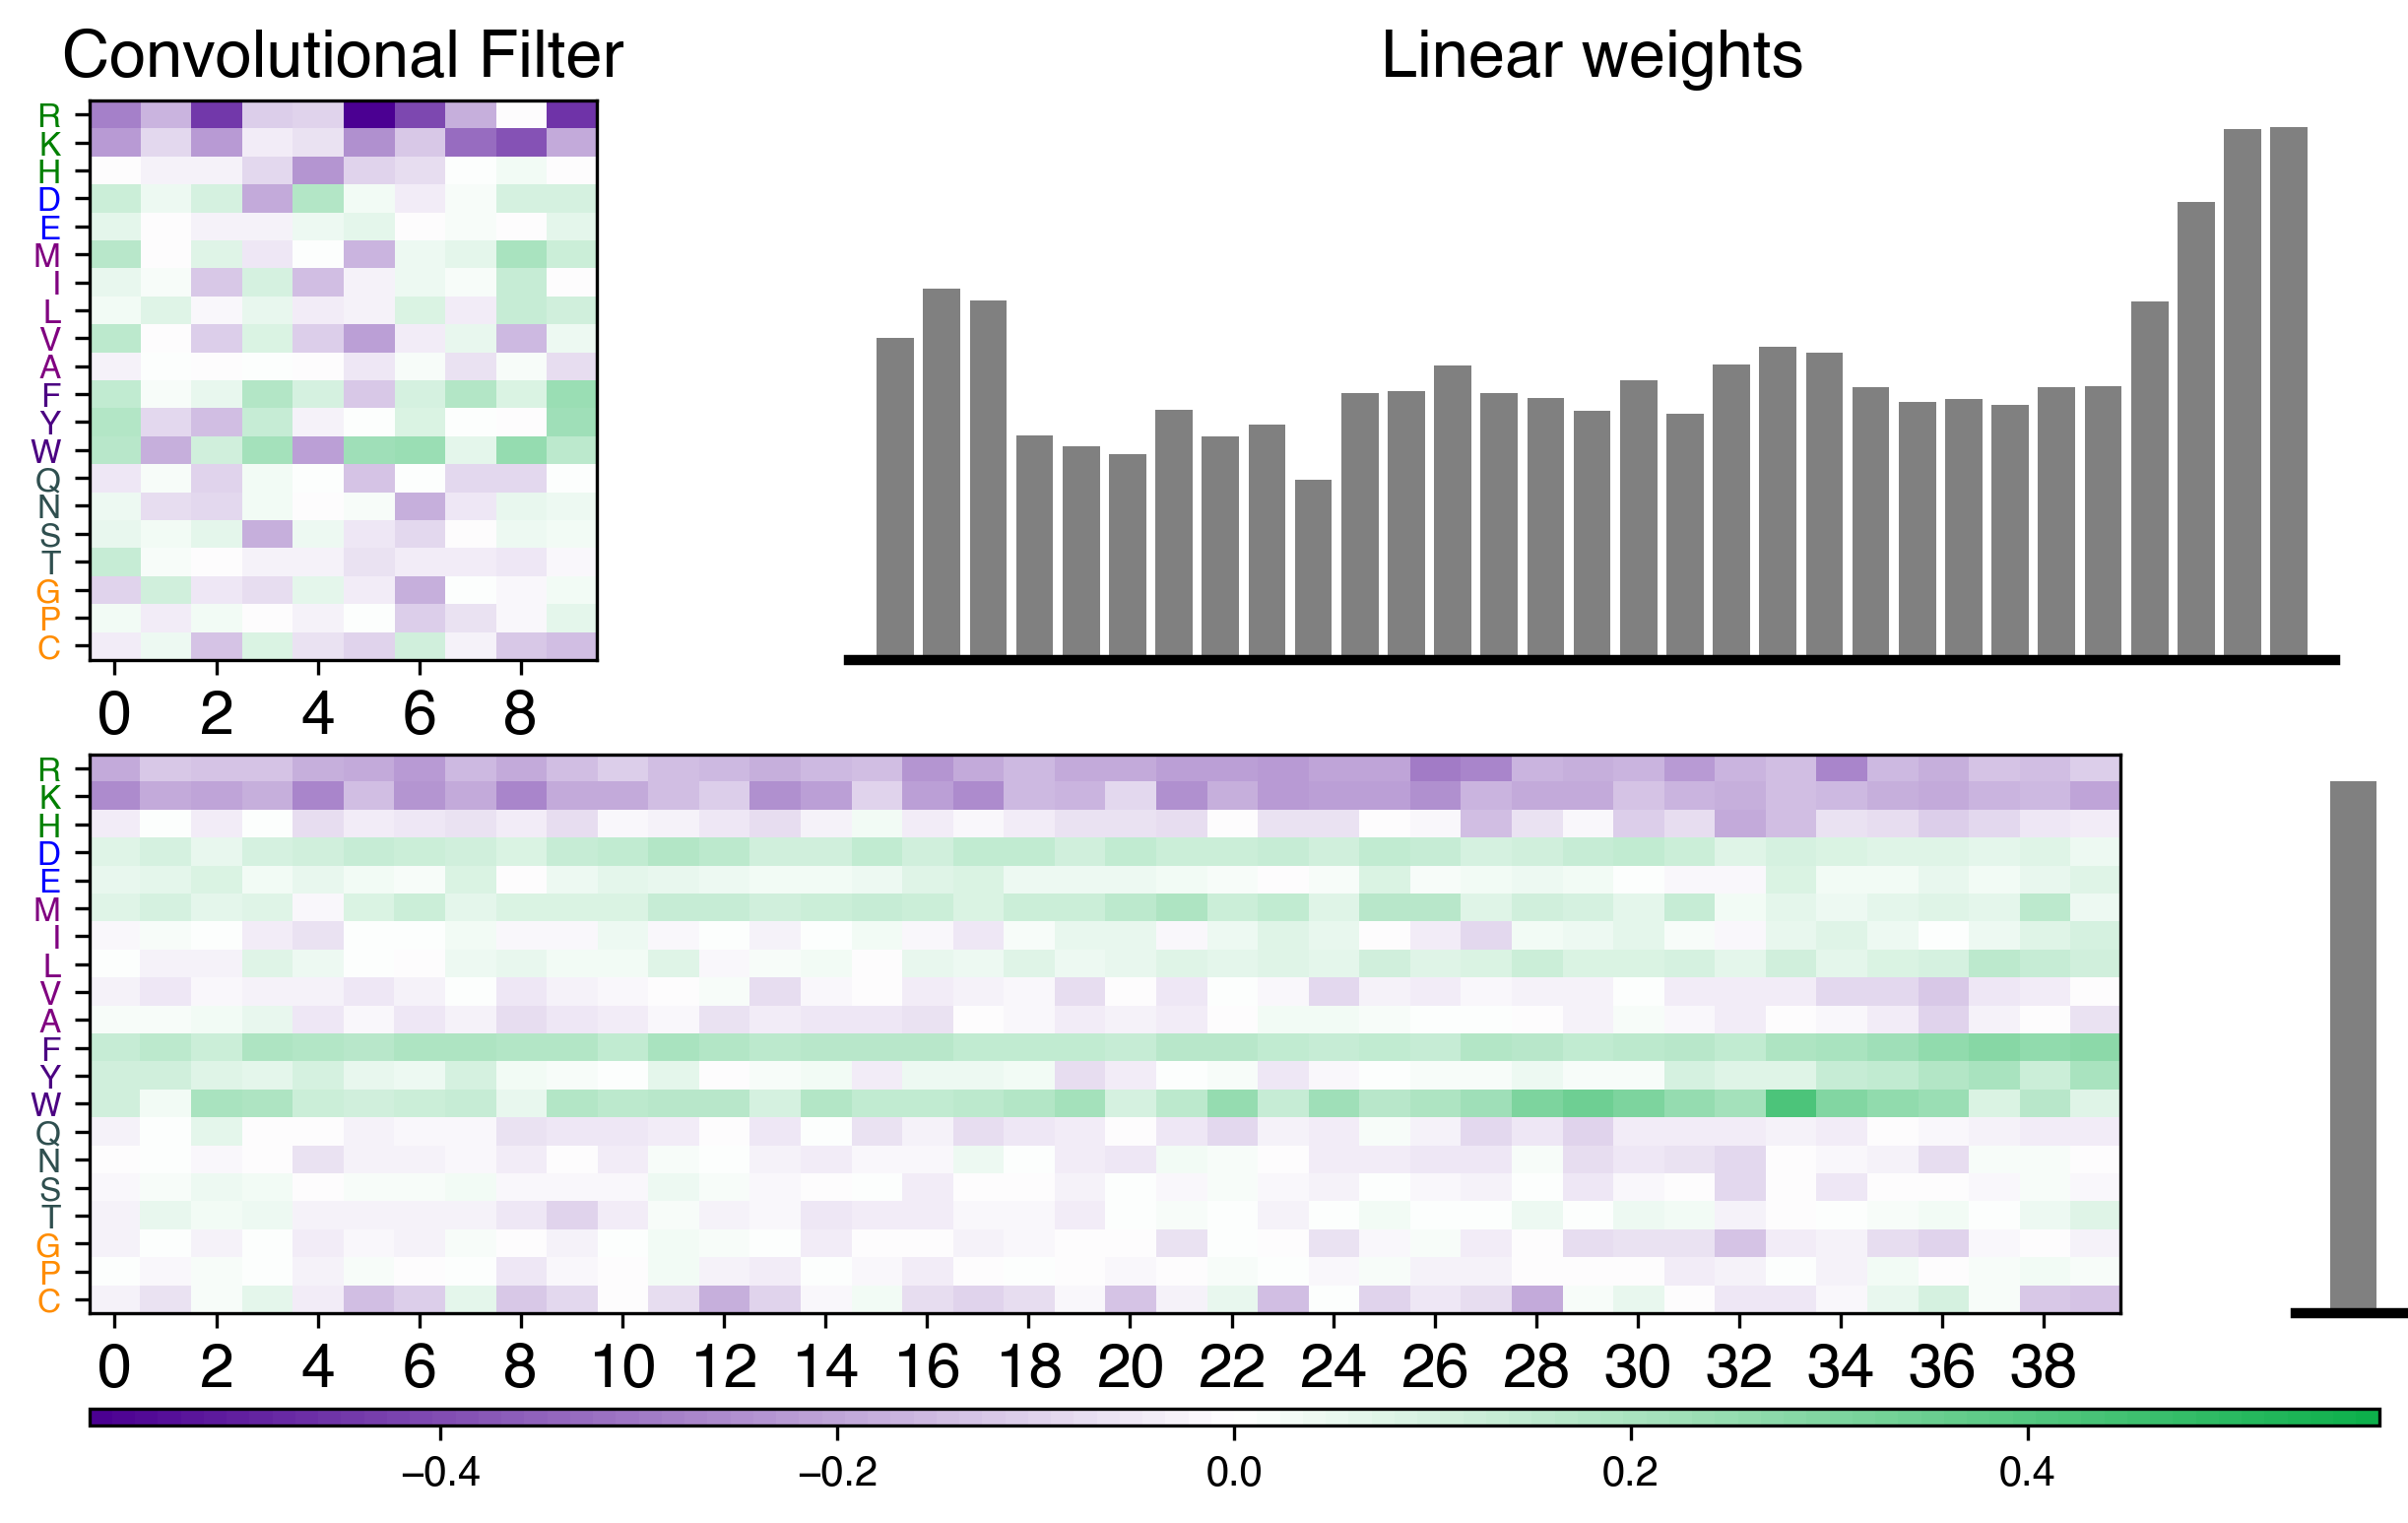

In [ ]:
num_rows = 2

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))

height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot(fig, 10, biophysical_model, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=16)
ax2.set_title("Linear weights", fontsize=16)

make_row_plot(fig, 40, model_40, 3, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("figures/simple_activity_parameters.pdf", format='pdf', bbox_inches='tight')


# Make plot for all filters

In [ ]:
# Best size 5 kernel
file = "model_data/simple_actmodel_b10_e200_L0.0001_sMinMax_c1_k5_wp0.1_ParaReLU_hSplit_seed5273651_weightInit"
model_5 = load_model(file, 5)

# Best size 15 kernel
file = "model_data/simple_actmodel_b10_e200_L0.0001_sMinMax_c1_k15_wp0.1_ParaReLU_hSplit_seed5273589_weightInit"
model_15 = load_model(file, 15)

# Best size 20 kernel
file = "model_data/simple_actmodel_b10_e200_L0.0001_sMinMax_c1_k20_wp0.1_ParaReLU_hSplit_seed27914497_weightInit"
model_20 = load_model(file, 20)

# Best size 30 kernel
file = "model_data/simple_actmodel_b10_e200_L0.0001_sMinMax_c1_k30_wp0.1_ParaReLU_hSplit_seed1834070_weightInit"
model_30 = load_model(file, 30)

# Best size 40 kernel 
file = "model_data/simple_actmodel_b10_e200_L0.0001_sMinMax_c1_k40_wp0.1_ParaReLU_hSplit_seed82375840_weightInit"
model_40 = load_model(file, 40)


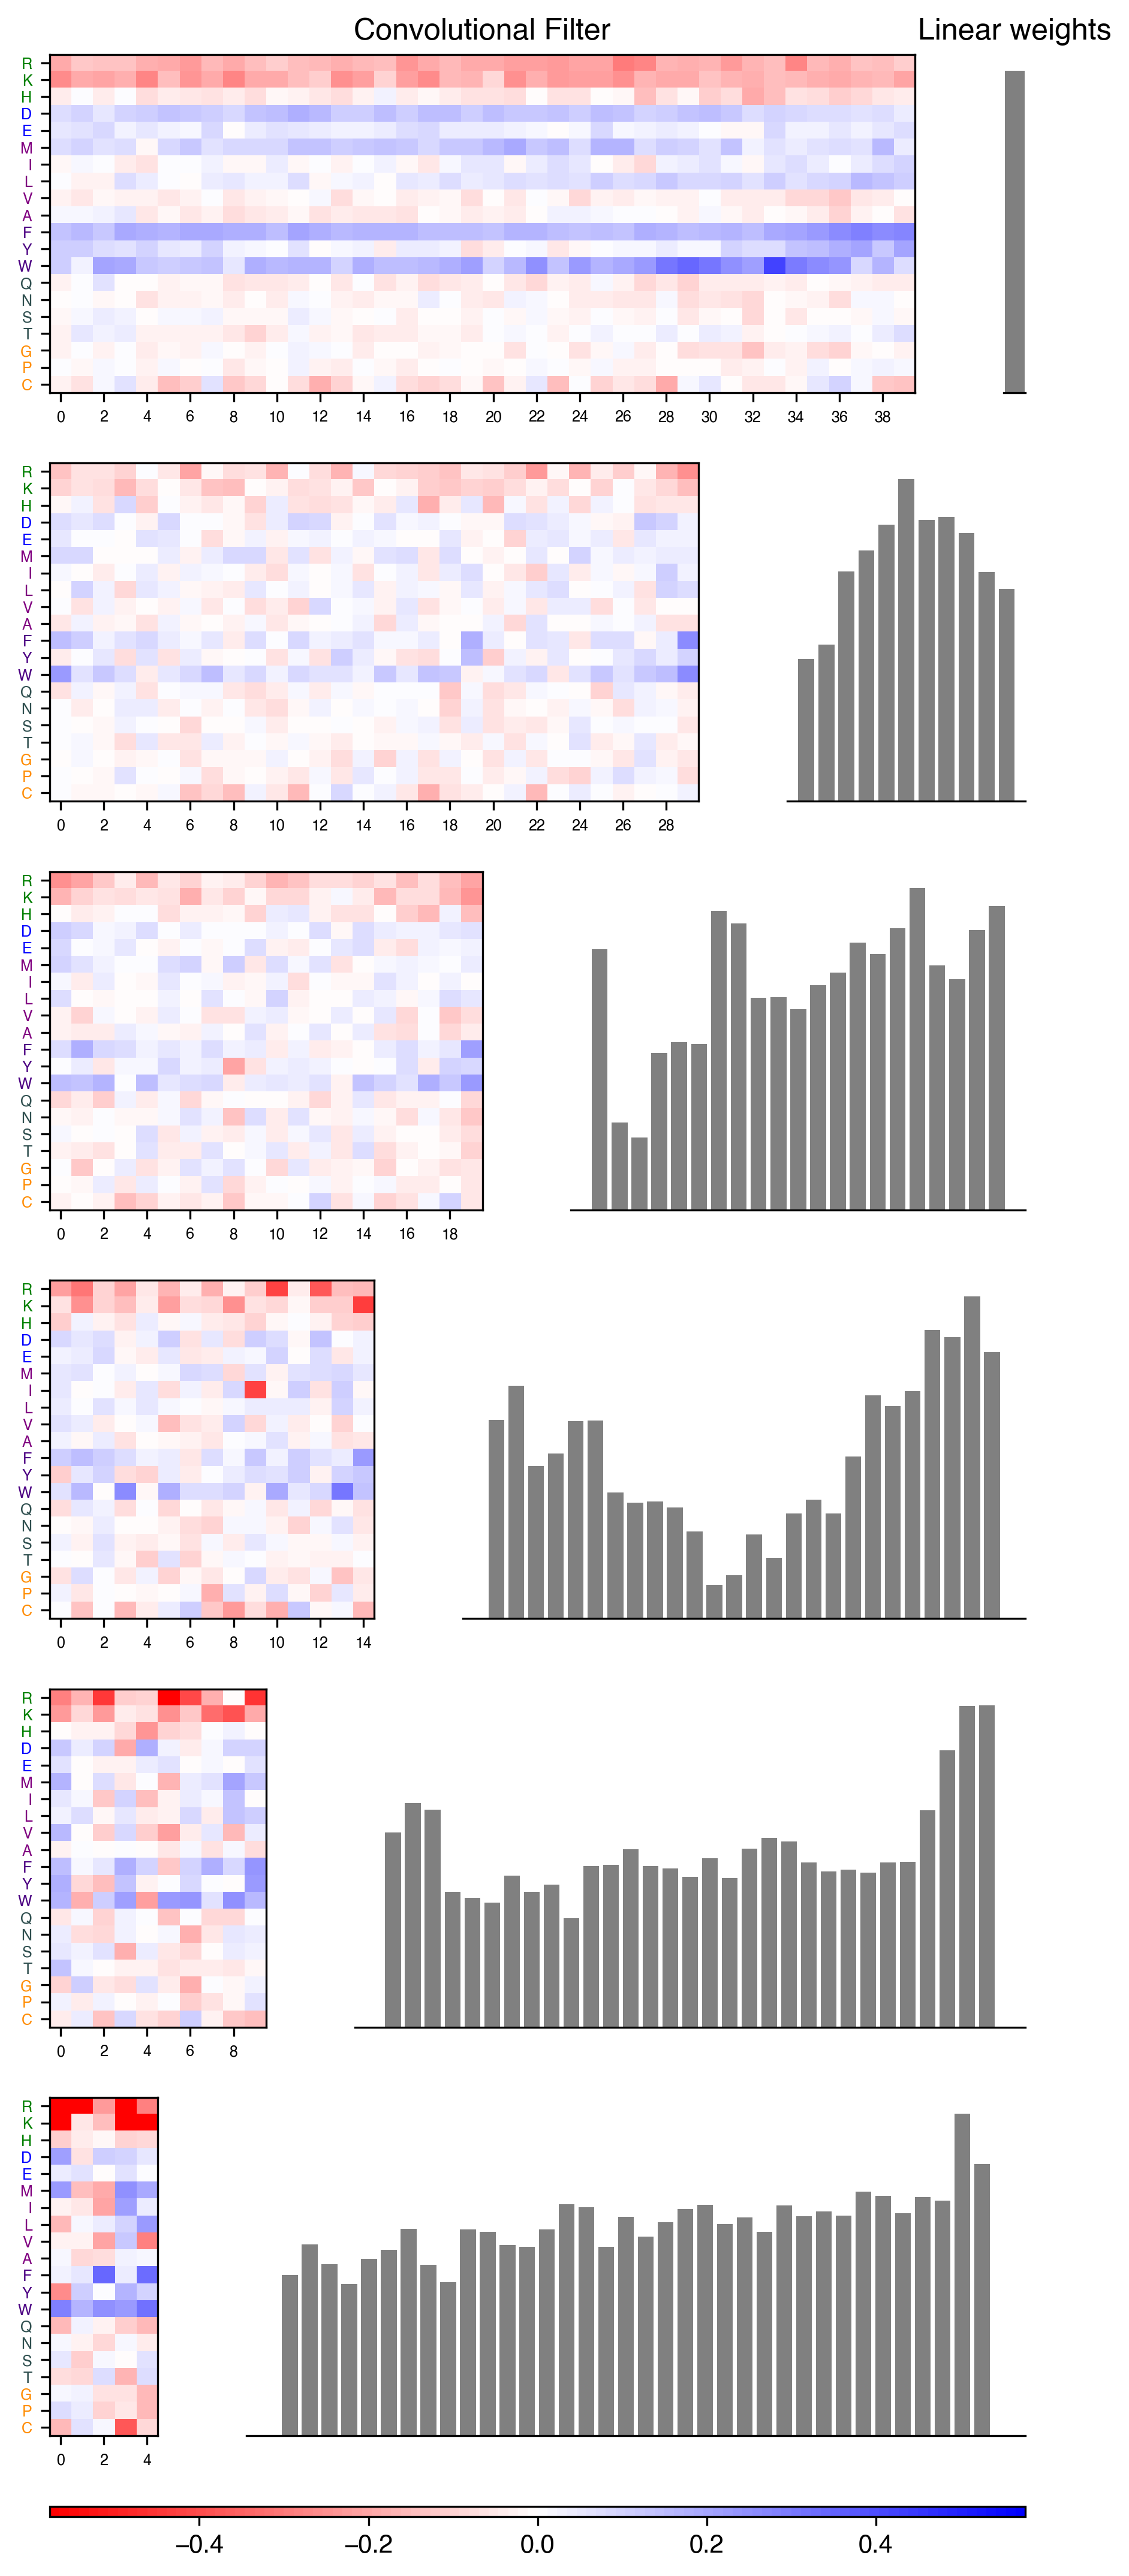

In [ ]:
num_rows = 6

# Create a figure
fig = plt.figure(figsize=(7, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot(fig, 40, model_40, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)

make_row_plot(fig, 30, model_30, 3, lim, height_ratios, num_rows)
make_row_plot(fig, 20, model_20, 5, lim, height_ratios, num_rows)
make_row_plot(fig, 15, model_15, 7, lim, height_ratios, num_rows)
make_row_plot(fig, 10, biophysical_model, 9, lim, height_ratios, num_rows)
make_row_plot(fig, 5, model_5, 11, lim, height_ratios, num_rows)

gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])


# Add the colorbar
fig.colorbar(im1,cax=cax1, orientation='horizontal')


# plt.savefig('figures/feature_interpretability_abundance_all_vs_all.pdf', dpi=1000, bbox_inches='tight')
# plt.savefig('figures/feature_interpretability_abundance_all_vs_all.png', dpi=1000, bbox_inches='tight')